In [1]:
%matplotlib inline

# Unsupervised Learning

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

![Clustering example]("https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png")

In [55]:
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import cycle, islice

np.random.seed(0)

#### 
# Pandas df with companies properties
####

df = pd.DataFrame({
    'bbg_ticker': ['AAPL US Equity', 'MSFT US Equity', 'GOOG US Equity', 'XOM Eq', 'NVD', 'Trillo', 'Ballo'],
    'pe': [20, 15, 30, 10, 5, 4, 6],
    'roa': [0.3, 0.2, 0.01, 1.1, 0.7, 0.4, 0.7],
    'country': ['US', 'US', 'UK', 'FR', 'IT', 'DE', 'US'],
    'pnl': [1, 0, 1, 0, 0, 1, 1],
})

# display(df)


#### 
# Pandas df trading behaviour
####


df = pd.DataFrame({
    'bbg_consensus_pe_mean': np.random.normal(10, 10, 1000), # bbg consensus on PE
    'bbg_consensus_pe_std': np.random.uniform(0, 10, 1000), # bbg std on consensus on PE
    'momentum': np.random.beta(1, 3, 1000)-0.3, # bbg std on consensus on PE
    'pnl': [1 if x > 0 else 0 for x in np.random.uniform(-1, 1, 1000)],
})

display(df)

,bbg_consensus_pe_mean,bbg_consensus_pe_std,momentum,pnl
0,27.640523,8.219039,0.182622,1
1,14.001572,7.005286,0.025245,0
2,19.787380,8.830776,0.008718,0
3,32.408932,9.665751,-0.238508,0
4,28.675580,7.747476,0.141719,0
...,...,...,...,...
995,14.128708,5.035278,-0.075288,0
996,8.016011,6.208416,-0.050451,0
997,10.941923,8.329885,-0.263289,1
998,-1.476109,5.645971,-0.232168,0


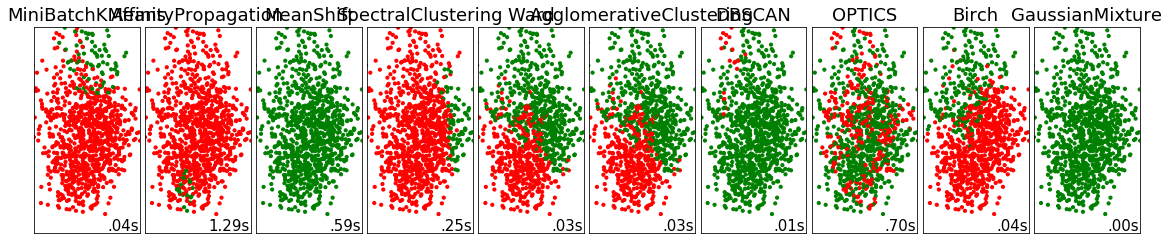

In [70]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(16, 6))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'min_cluster_size': 0.1,
                'quantile': .2,
                'n_clusters': 2,
                'min_samples': 20,
                'xi': 0.25}

X, y = (df.drop('pnl', axis=1), df.pnl)

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

#####
# Algo preps
#####

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)


#####
# Create cluster objects
#####

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans()
ward = cluster.AgglomerativeClustering()
spectral = cluster.SpectralClustering()
dbscan = cluster.DBSCAN()
optics = cluster.OPTICS()
affinity_propagation = cluster.AffinityPropagation()
average_linkage = cluster.AgglomerativeClustering()
birch = cluster.Birch()
gmm = mixture.GaussianMixture()

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('OPTICS', optics),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

pca = PCA(n_components=2)
XX = pca.fit_transform(X)

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    plt.scatter(XX[:, 0], XX[:, 1], s=10, color=['r' if _y>0 else 'g' for _y in y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1
    
plt.show()